# CSCA 5642 Week 3 Histopathologic Cancer Detection

The goal is to develop an algorithm capable of detecting metastatic cancer within small image patches extracted from high-resolution digital pathology scans. This task is part of a broader challenge in computational pathology and has important implications for improving cancer diagnosis through automated methods.

## Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers.schedules import CosineDecay

### Data Path

In [6]:
# Path settings

is_kaggle = False

if is_kaggle:
    # kagglt's data are under /kaggle/input
    path_prefix = '/kaggle/input'
else:
    # local path
    path_prefix = '..'

TRAIN_PATH = f'{path_prefix}/histopathologic-cancer-detection/train/'
TEST_PATH = f'{path_prefix}/histopathologic-cancer-detection/test/'
TRAIN_LABELS = f'{path_prefix}/histopathologic-cancer-detection/train_labels.csv'
SAMPLE_SUBMISSION = f'{path_prefix}/histopathologic-cancer-detection/sample_submission.csv'


#### Exploring Labels

In [7]:
train_df = pd.read_csv(TRAIN_LABELS)
print(f"Training data shape: {train_df.shape}")
print(train_df.head())

Training data shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [8]:
# get unique labels
labels = train_df['label'].unique()
print(f"Unique labels: {labels}")

Unique labels: [0 1]


The label data is a simple csv with id and label where label consists of just 0s and 1s. We will assume that 1 represents cancer-positive image where as 0 represents cancer-free image.

Now let's check if the training data is well balanced.

In [9]:
# get the number of samples for each label
label_counts = train_df['label'].value_counts()
print(label_counts)

0    130908
1     89117
Name: label, dtype: int64


<Axes: title={'center': 'Label distribution'}>

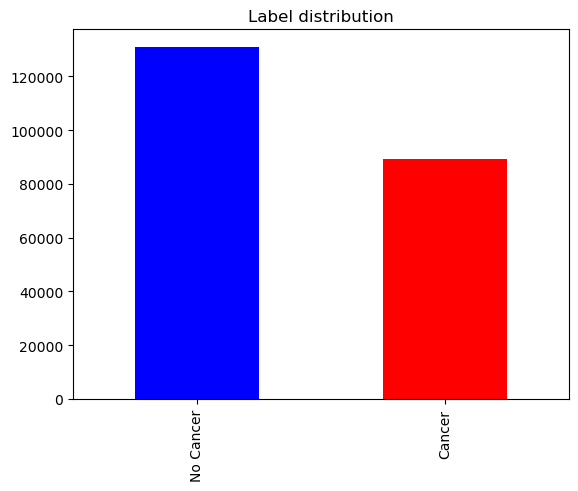

In [10]:
train_df['label'].map({0: 'No Cancer', 1: 'Cancer'}).value_counts().plot(kind='bar', title='Label distribution', color=['blue', 'red'])

#### Exploring Images

In [11]:
# Display pixel size of a sample image
img = load_img(TRAIN_PATH + train_df.iloc[0]['id'] + '.tif')
print(f"Image size: {img.size}")

Image size: (96, 96)


Images are 96 by 96 pixels

In [12]:
def display_sample_images(df, img_path):
    
    cancer_samples = df[df['label'] == 1]['id'].sample(5).values
    non_cancer_samples = df[df['label'] == 0]['id'].sample(5).values
    
    _, axes = plt.subplots(2, 5)
    
    # Display cancer samples
    for i, sample_id in enumerate(cancer_samples):
        img = load_img(os.path.join(img_path, sample_id + '.tif'))
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Cancer")
        axes[0, i].axis('off')
    
    # Display non-cancer samples
    for i, sample_id in enumerate(non_cancer_samples):
        img = load_img(os.path.join(img_path, sample_id + '.tif'))
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Cancer Free")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()
    
    return cancer_samples, non_cancer_samples

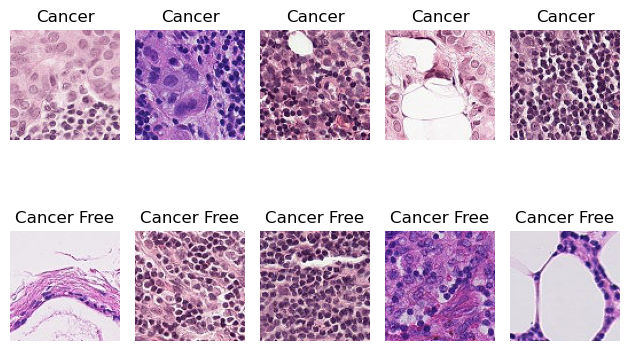

In [13]:
cancer_samples, non_cancer_samples = display_sample_images(train_df, TRAIN_PATH)

There is no visible obvious sign of what constitutes cancer images vs cancer free images.

In [14]:

def analyze_image_characteristics(sample_ids):
    
    # Arrays to store metrics
    brightness_values = []
    contrast_values = []
    red_channel_values = []
    green_channel_values = []
    blue_channel_values = []
    
    # Process each image
    for sample_id in sample_ids:
        img_file = os.path.join(TRAIN_PATH, sample_id + '.tif')
        
        # Convert image to Shape of (height, width, channels) where the channels are RGB
        img = np.array(Image.open(img_file))
        
        # Calculate brightness (mean pixel value)
        brightness = np.mean(img)
        brightness_values.append(brightness)
        
        # Calculate contrast (standard deviation of pixel values)
        contrast = np.std(img)
        contrast_values.append(contrast)
        
        # Calculate color distribution (mean of each channel)
        redness = np.mean(img[:,:,0])
        red_channel_values.append(redness)
        greenness = np.mean(img[:,:,1])
        green_channel_values.append(greenness)
        blueness = np.mean(img[:,:,2])
        blue_channel_values.append(blueness)
    
    return {
        'brightness': brightness_values,
        'contrast': contrast_values,
        'red_channel': red_channel_values,
        'green_channel': green_channel_values,
        'blue_channel': blue_channel_values
    }

cancer_samples = train_df[train_df['label'] == 1]['id'].sample(100).values
non_cancer_samples = train_df[train_df['label'] == 0]['id'].sample(100).values

print(cancer_samples.shape, non_cancer_samples.shape)

# Analyze characteristics for both classes
cancer_characteristics = analyze_image_characteristics(cancer_samples)
non_cancer_characteristics = analyze_image_characteristics(non_cancer_samples)


(100,) (100,)


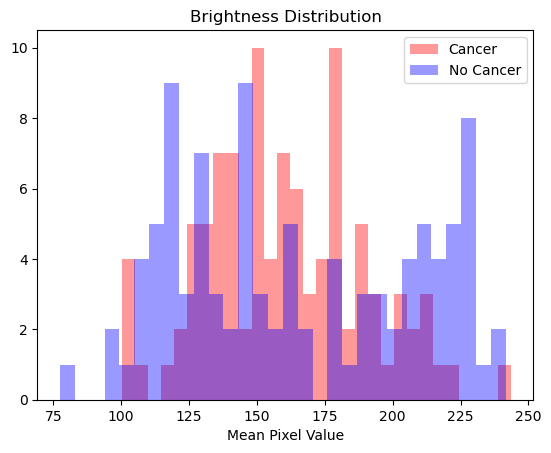

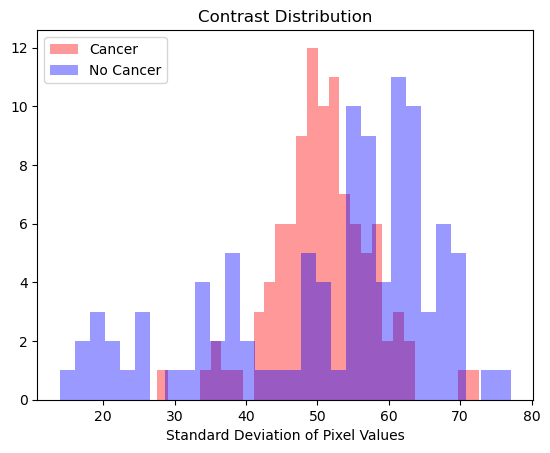

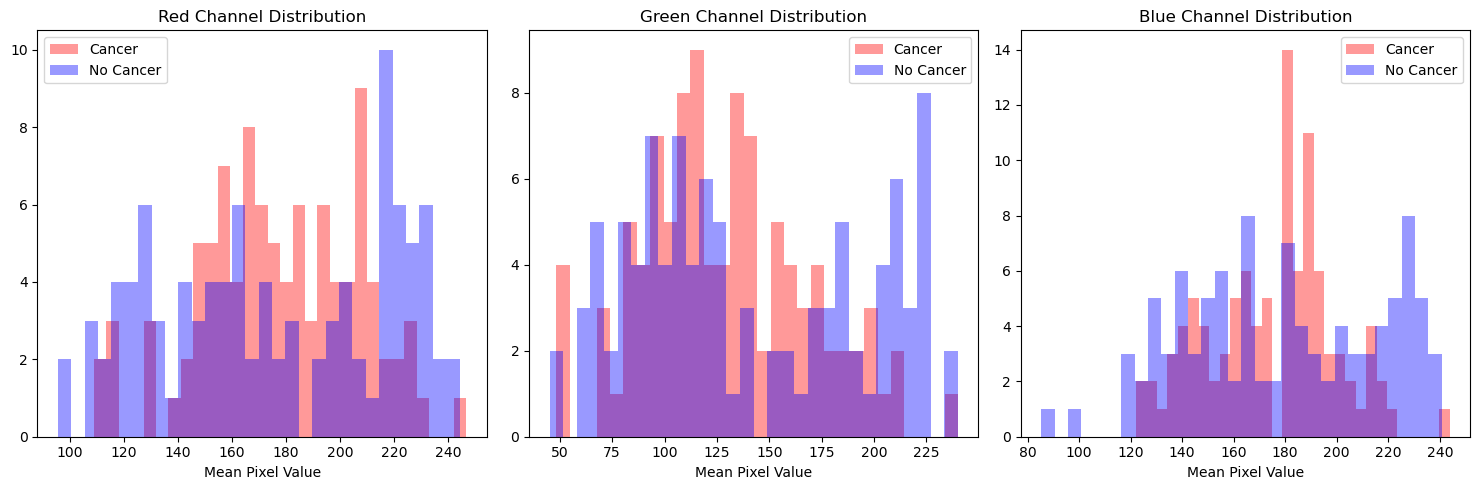

In [15]:
# Plot brightness comparison
plt.hist(cancer_characteristics['brightness'], alpha=0.4, label='Cancer', bins=30, color='red')
plt.hist(non_cancer_characteristics['brightness'], alpha=0.4, label='No Cancer', bins=30, color='blue')
plt.title('Brightness Distribution')
plt.xlabel('Mean Pixel Value')
plt.legend()
plt.show()

# Plot contrast comparison
plt.hist(cancer_characteristics['contrast'], alpha=0.4, label='Cancer', bins=30, color='red')
plt.hist(non_cancer_characteristics['contrast'], alpha=0.4, label='No Cancer', bins=30, color='blue')
plt.title('Contrast Distribution')
plt.xlabel('Standard Deviation of Pixel Values')
plt.legend()
plt.show()

# Plot color distributions
plt.figure(figsize=(15, 5))
# Red
plt.subplot(1, 3, 1)
plt.hist(cancer_characteristics['red_channel'], alpha=0.4, label='Cancer', bins=30, color='red')
plt.hist(non_cancer_characteristics['red_channel'], alpha=0.4, label='No Cancer', bins=30, color='blue')
plt.title('Red Channel Distribution')
plt.xlabel('Mean Pixel Value')
plt.legend()

# Green
plt.subplot(1, 3, 2)
plt.hist(cancer_characteristics['green_channel'], alpha=0.4, label='Cancer', bins=30, color='red')
plt.hist(non_cancer_characteristics['green_channel'], alpha=0.4, label='No Cancer', bins=30, color='blue')
plt.title('Green Channel Distribution')
plt.xlabel('Mean Pixel Value')
plt.legend()

# Blue
plt.subplot(1, 3, 3)
plt.hist(cancer_characteristics['blue_channel'], alpha=0.4, label='Cancer', bins=30, color='red')
plt.hist(non_cancer_characteristics['blue_channel'], alpha=0.4, label='No Cancer', bins=30, color='blue')
plt.title('Blue Channel Distribution')
plt.xlabel('Mean Pixel Value')
plt.legend()

plt.tight_layout()
plt.show()

While there is no clear distinction between the any of the image characteristics of cancer anc cancer free images, cancer images seem to have less deviations between the characteristics.

In [16]:
cancer_spread = np.std(cancer_characteristics['brightness'])
non_cancer_spread = np.std(non_cancer_characteristics['brightness'])

print(f"Brightness Cancer standard deviation: {cancer_spread:.2f}")
print(f"Brightness No Cancer standard deviation: {non_cancer_spread:.2f}")

Brightness Cancer standard deviation: 29.42
Brightness No Cancer standard deviation: 43.52


In [17]:
cancer_spread = np.std(cancer_characteristics['contrast'])
non_cancer_spread = np.std(non_cancer_characteristics['contrast'])

print(f"contrast Cancer standard deviation: {cancer_spread:.2f}")
print(f"contrast No Cancer standard deviation: {non_cancer_spread:.2f}")

contrast Cancer standard deviation: 6.96
contrast No Cancer standard deviation: 15.36


In [18]:
cancer_spread = np.std(cancer_characteristics['red_channel'])
non_cancer_spread = np.std(non_cancer_characteristics['red_channel'])

print(f"red_channel Cancer standard deviation: {cancer_spread:.2f}")
print(f"red_channel No Cancer standard deviation: {non_cancer_spread:.2f}")

red_channel Cancer standard deviation: 29.12
red_channel No Cancer standard deviation: 42.18


In [19]:
cancer_spread = np.std(cancer_characteristics['green_channel'])
non_cancer_spread = np.std(non_cancer_characteristics['green_channel'])

print(f"green_channel Cancer standard deviation: {cancer_spread:.2f}")
print(f"green_channel No Cancer standard deviation: {non_cancer_spread:.2f}")

green_channel Cancer standard deviation: 39.64
green_channel No Cancer standard deviation: 54.70


In [20]:
cancer_spread = np.std(cancer_characteristics['blue_channel'])
non_cancer_spread = np.std(non_cancer_characteristics['blue_channel'])

print(f"blue_channel Cancer standard deviation: {cancer_spread:.2f}")
print(f"blue_channel No Cancer standard deviation: {non_cancer_spread:.2f}")

blue_channel Cancer standard deviation: 24.52
blue_channel No Cancer standard deviation: 37.38


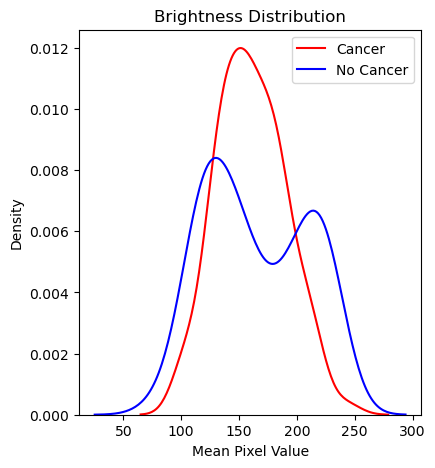

In [21]:
# graph the desity distribution of brightness
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(cancer_characteristics['brightness'], label='Cancer', color='red')
sns.kdeplot(non_cancer_characteristics['brightness'], label='No Cancer', color='blue')
plt.title('Brightness Distribution')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Density')
plt.legend()

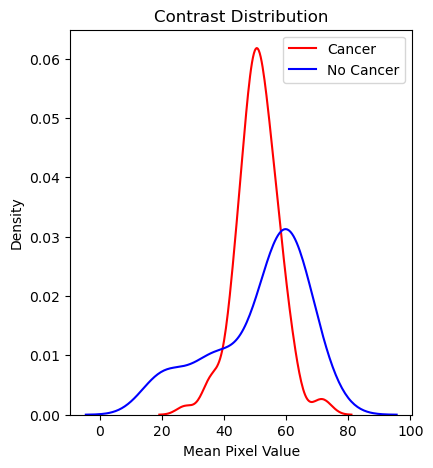

In [22]:
# graph the desity distribution of brightness
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(cancer_characteristics['contrast'], label='Cancer', color='red')
sns.kdeplot(non_cancer_characteristics['contrast'], label='No Cancer', color='blue')
plt.title('Contrast Distribution')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Density')
plt.legend()

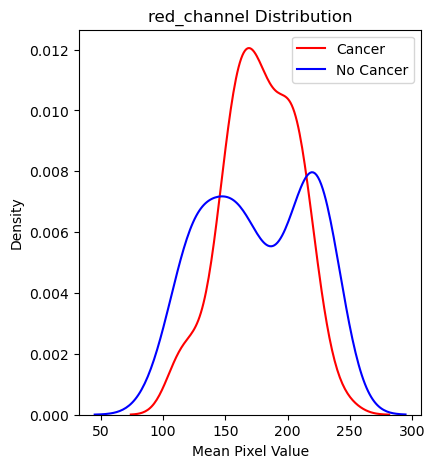

In [23]:
# graph the desity distribution of red_channel
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(cancer_characteristics['red_channel'], label='Cancer', color='red')
sns.kdeplot(non_cancer_characteristics['red_channel'], label='No Cancer', color='blue')
plt.title('red_channel Distribution')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Density')
plt.legend()

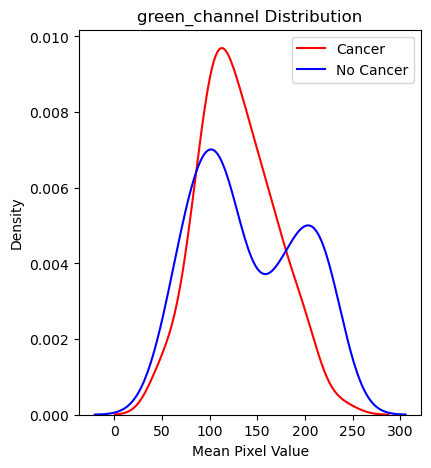

In [24]:
# graph the desity distribution of green_channel
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(cancer_characteristics['green_channel'], label='Cancer', color='red')
sns.kdeplot(non_cancer_characteristics['green_channel'], label='No Cancer', color='blue')
plt.title('green_channel Distribution')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Density')
plt.legend()

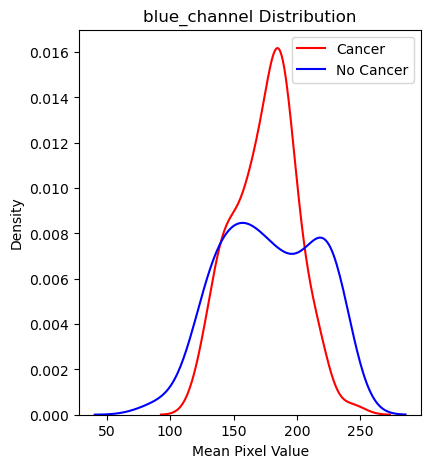

In [25]:
# graph the desity distribution of blue_channel
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(cancer_characteristics['blue_channel'], label='Cancer', color='red')
sns.kdeplot(non_cancer_characteristics['blue_channel'], label='No Cancer', color='blue')
plt.title('blue_channel Distribution')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Density')
plt.legend()

## Building CNN model with Keras

In [ ]:
# Build the CNN model
LEARNING_RATE = 0.001


def build_model():
    model = Sequential([
        # First convolutional block
        # use padding='same' to preserve the input dimensions
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Fourth convolutional block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# Create and summary the model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

### Preprocessing

Here are some preprocessing that we will do.
- Sample pre-selected size of training image that we will train on.  (For development we will not train on all images)
- Load the image and convert to (height, width, RGB_channel) so it (96, 96, 3), with values from (0, 255)
- Divide by 255 to normalize the values so the values are from (0, 1]
- Slice the array into (32,32,3) that represents the pixels in the center

In [27]:
def preprocess_images(df, max_samples = None):
    
    # Just get all data if max_samples is None
    if max_samples is None:
        sample = df
    else:
        max_sample_per_class = max_samples // 2

        # Sample the data
        cancer_samples = df[df['label'] == 1].sample(max_sample_per_class)
        non_cancer_samples = df[df['label'] == 0].sample(max_sample_per_class)
        
        sample = pd.concat([cancer_samples, non_cancer_samples])
    
        # Shuffle the data
        sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)
    
    images = []
    labels = []
    
    for idx, row in sample.iterrows():

        img_file_path = os.path.join(TRAIN_PATH, row['id'] + '.tif')
        img = load_img(img_file_path)
        # Convert to array with shape (96, 96, 3) and values from 0-255
        img_array = img_to_array(img)
        
        # Normalize values to range 0-1
        img_array = img_array / 255.0
        
        # Extract the center 32x32 region
        center_region = img_array[32:64, 32:64, :]
        images.append(center_region)
        
        # Add the label
        labels.append(row['label'])
    
    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    print(f"Loaded data shapes - X: {X.shape}, y: {y.shape}")
    return X, y
    


# SAMPLE_SIZE = 10000
SAMPLE_SIZE = 40000

X, y = preprocess_images(train_df, SAMPLE_SIZE)

Loaded data shapes - X: (40000, 32, 32, 3), y: (40000,)


In [28]:
print(y[0:50])

[0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 1]


### Fitting the Model

In [29]:

EPOCHS = 15

history = model.fit(X, y, epochs=EPOCHS, validation_split=0.3)

Epoch 1/15
875/875 [==============================] - 19s 21ms/step - loss: 0.5463 - accuracy: 0.7259 - auc: 0.8003 - val_loss: 0.5110 - val_accuracy: 0.7654 - val_auc: 0.8393
Epoch 2/15
875/875 [==============================] - 19s 21ms/step - loss: 0.5029 - accuracy: 0.7640 - auc: 0.8359 - val_loss: 0.4954 - val_accuracy: 0.7692 - val_auc: 0.8491
Epoch 3/15
875/875 [==============================] - 19s 22ms/step - loss: 0.4847 - accuracy: 0.7765 - auc: 0.8484 - val_loss: 0.4958 - val_accuracy: 0.7596 - val_auc: 0.8594
Epoch 4/15
875/875 [==============================] - 18s 21ms/step - loss: 0.4700 - accuracy: 0.7848 - auc: 0.8587 - val_loss: 0.4585 - val_accuracy: 0.7893 - val_auc: 0.8664
Epoch 5/15
875/875 [==============================] - 18s 21ms/step - loss: 0.4561 - accuracy: 0.7899 - auc: 0.8675 - val_loss: 0.4527 - val_accuracy: 0.7942 - val_auc: 0.8704
Epoch 6/15
875/875 [==============================] - 18s 21ms/step - loss: 0.4408 - accuracy: 0.8002 - auc: 0.8767 - va

### Plot the traning result

In [30]:
def plot_training_history(history, number):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    # Loss plot
    ax2.plot(history.history['loss'][1:])
    ax2.plot(history.history['val_loss'][1:])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'training_history_{number}.png')
    plt.show()



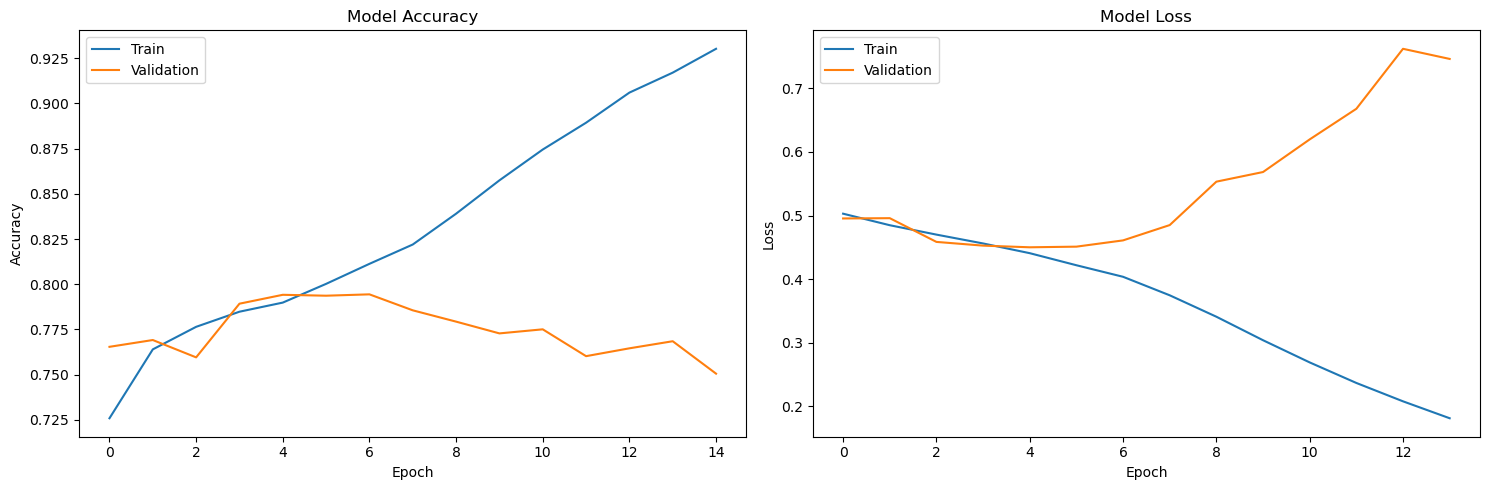

In [31]:
plot_training_history(history, 1)

### Model 1 evalutaion

With just 15 epochs, the accuracy did not reach acceptable rate. The validation accuracy also did not converge.



In [174]:
len(y)

40000

In [51]:
# Build the CNN model
# Use cosine decay which often works better than step decay
EPOCHS = 20
BATCH_SIZE = 128

decay_steps = EPOCHS * (len(X) // BATCH_SIZE)

print(decay_steps)

lr_schedule = CosineDecay(
    initial_learning_rate = 0.02,
    decay_steps = decay_steps,
    alpha=0.005  # Minimum learning rate as a fraction of initial rate
)


def build_model2():
    model = Sequential([

        Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        
        # Flatten and dense layers
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# Create and summary the model
model2 = build_model2()
model2.summary()

6240
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_14 (Bat  (None, 16, 16, 128)

#### Model 2 Changes

- Increase the initial filter from 32 to 64
- Used Cosine Decay for learning rate scheduling
- Increased the batch size for faster training
- Move to Conv -> Batch Normalization -> Conv -> MaxPool
- Used only 1 Dense layer

This increased the training paremeter to 2.3MM


In [52]:
history2 = model2.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 70s 278ms/step - loss: 8.4073 - accuracy: 0.5746 - auc_3: 0.6033 - val_loss: 0.6685 - val_accuracy: 0.5981 - val_auc_3: 0.6117
Epoch 2/20
250/250 [==============================] - 69s 277ms/step - loss: 0.6076 - accuracy: 0.6903 - auc_3: 0.7323 - val_loss: 0.9145 - val_accuracy: 0.4728 - val_auc_3: 0.4589
Epoch 3/20
250/250 [==============================] - 67s 268ms/step - loss: 0.5040 - accuracy: 0.7693 - auc_3: 0.8329 - val_loss: 0.6843 - val_accuracy: 0.6378 - val_auc_3: 0.6944
Epoch 4/20
250/250 [==============================] - 72s 287ms/step - loss: 0.4770 - accuracy: 0.7817 - auc_3: 0.8547 - val_loss: 0.5470 - val_accuracy: 0.7320 - val_auc_3: 0.8050
Epoch 5/20
250/250 [==============================] - 68s 273ms/step - loss: 0.4673 - accuracy: 0.7876 - auc_3: 0.8625 - val_loss: 0.5546 - val_accuracy: 0.7221 - val_auc_3: 0.8132
Epoch 6/20
250/250 [==============================] - 70s 279ms/step - loss: 0.4746 - accuracy:

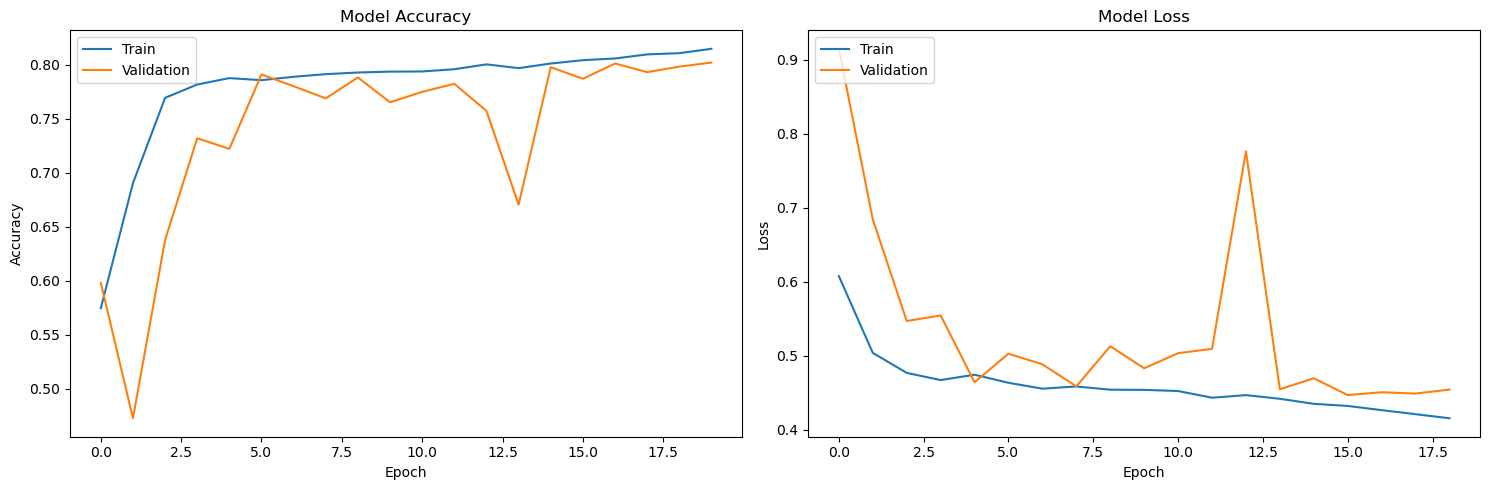

In [53]:
plot_training_history(history2, 2)

### Model 2 Analysis

The learning rate, even with scheduling was too aggressive.  (Starting from 0.02 down to 0.0001) 
While the training accuracy increased, the model kept missing the true minima.

In [36]:
# Build the CNN model
# Use cosine decay which often works better than step decay
EPOCHS = 25
BATCH_SIZE = 64

def build_model3():
    model = Sequential([

        Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Create and summary the model
model3 = build_model3()
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_8 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

### Model 3 Changes
- Move back to just Conv -> Batch Normalization -> MaxPool
- Added another Dense layer
- Added Dropout for Dense layers
- Increased the kernel size for Dense layers
- Decreased the learning rate to 0.00001
- Decreased the batch size to 64

Also sets the callbacks of
- Early Stopping
- Checkpoint
- Reduce learning rate even more on plateuing of validation loss

In [37]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',  # Changed from val_auc to val_auc_13 
        mode='max',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model checkpoint to save the best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_3.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    # Other callbacks remain the same
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=5e-7,
        verbose=1
    ),
]


history3 = model3.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)


Epoch 1/25
500/500 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.6872 - auc: 0.7489
Epoch 1: val_auc improved from -inf to 0.80037, saving model to best_model_3.h5
500/500 [==============================] - 48s 94ms/step - loss: 0.7282 - accuracy: 0.6872 - auc: 0.7489 - val_loss: 0.8525 - val_accuracy: 0.6376 - val_auc: 0.8004 - lr: 1.0000e-04
Epoch 2/25
500/500 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.7428 - auc: 0.8189
Epoch 2: val_auc improved from 0.80037 to 0.85527, saving model to best_model_3.h5
500/500 [==============================] - 48s 96ms/step - loss: 0.5396 - accuracy: 0.7428 - auc: 0.8189 - val_loss: 0.5209 - val_accuracy: 0.7600 - val_auc: 0.8553 - lr: 1.0000e-04
Epoch 3/25
500/500 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.7659 - auc: 0.8373
Epoch 3: val_auc improved from 0.85527 to 0.86373, saving model to best_model_3.h5
500/500 [==============================] - 50s 99ms/step - l

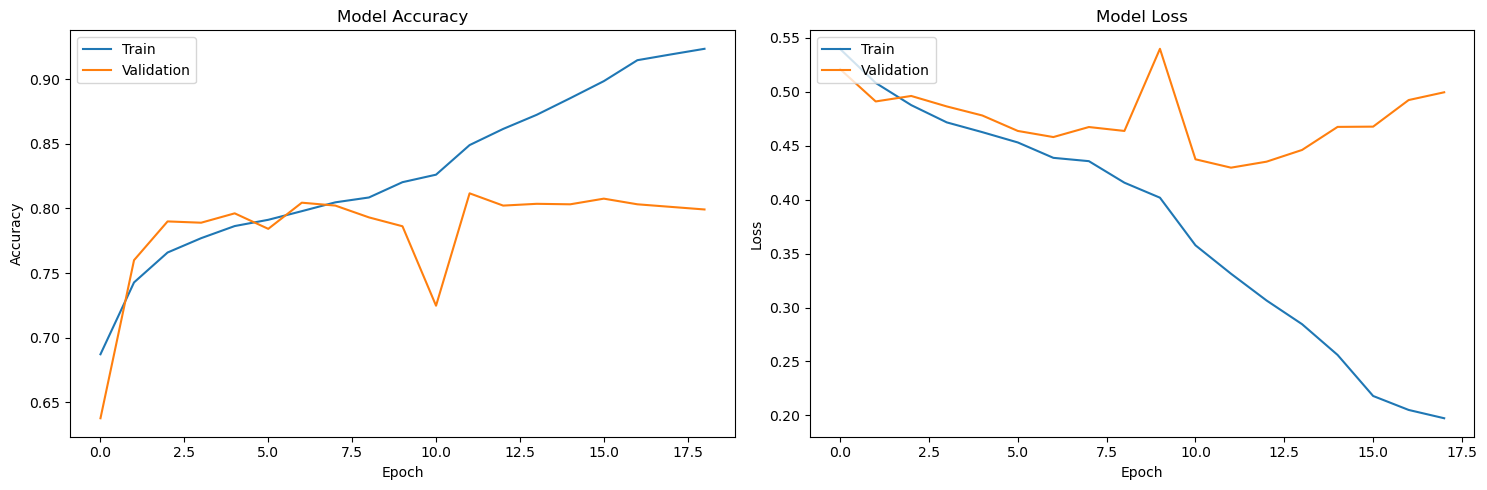

In [38]:
plot_training_history(history3, 3)

#### Model 3 Analysis

We were able to get the accuracy level high.  There was still overfitting, regularization with both Batch normalization and dropout helped.

Also increasing the initial filter size to 64 helped identify the cancel with more accuracy


## Prediction

In [39]:
def preprocess_test_images():
    
    # Prepare test data for evaluation.
    test_files = os.listdir(TEST_PATH)
    test_ids = []
    test_X = []

    for file in test_files:
        
        file_id = file.split('.')[0]
        
        test_ids.append(file_id)
        
        img = load_img(TEST_PATH + file)
        # Convert to array with shape (96, 96, 3) and values from 0-255
        img_array = img_to_array(img)
        
        # Normalize values to range 0-1
        img_array = img_array / 255.0
        
        # Extract the center 32x32 region
        center_region = img_array[32:64, 32:64, :]
        test_X.append(center_region)
        
    
    print(f"Loaded data shapes - X: {len(test_X)}, {len(test_ids)}")
    return np.array(test_X), np.array(test_ids)

In [40]:
test_X, test_ids = preprocess_test_images()

Loaded data shapes - X: 57458, 57458


In [42]:
predicted_X = model3.predict(test_X)

1796/1796 [==============================] - 34s 19ms/step


In [45]:
print(predicted_X.shape)
print(len(test_ids))

print(predicted_X[0:10])

(57458, 1)
57458
[[0.8004333 ]
 [0.77387935]
 [0.11805055]
 [0.27050388]
 [0.16491379]
 [0.13521545]
 [0.04792121]
 [0.08536937]
 [0.45297757]
 [0.5926146 ]]


In [47]:
csv_df = pd.DataFrame({
    'id': test_ids,
    'label': predicted_X.reshape(-1),
})

csv_df.to_csv('submit.csv', index=False)


## Conclusion

We were able to train the model without using GPU since the image size was relative small 32x32 pixels
Increasing the depth of the CNN allowed it to converge where shallow network was not able to
Starting with 64 filters instead of 32 filter helped.
The model worked better with very small learning rate.  Starting from 0.0001 down 0.000009